# Cálculo de la densidad máxima a una determinada temperatura para el SCR-1

El siguiente procedimiento está basado en el artículo: "Plasma parameter limits of magnetically confined low temperature plasmas from a combined particle and power balance". Se obtiene una expresión de densidad electrónica en función de la temperatura de los electrones y otros parámetros de la gas neutro a partir de un balance de energía y cantidad de partículas y los procesos atómicos involucrados en el plasma.
    

In [1]:
#Se importan las bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt #graficación
from scipy.constants import k,e, N_A
import math as math
from scipy import interpolate #interpolación 

#idioma = 'español'
idioma = 'ingles'

#Graficación

if idioma == 'español':
    #plt.prop_cycle(color=['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97'])
    #axes.prop_cycle : cycler('color', ['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97', '474747', '9e9e9e'])
    #Latex y coma como separador decimal
    plt.rcParams['text.usetex'] = True #latex
    #plt.rc('text', usetex=False)
    plt.rcParams['axes.formatter.use_locale'] = True #formato de eje para la coma
    #se incluye paquete matematico útil, se corrige el error con el espacio y el espacio entre los números
    plt.rc('text.latex', preamble=r'\usepackage{amsmath} \DeclareUnicodeCharacter{202F}{\,} \usepackage{ziffer} \usepackage{siunitx}') 
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
    })
    import locale #líbreria para el formato
    locale.setlocale(locale.LC_ALL, "es_CR.utf8")

if idioma == 'ingles' :
    plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{siunitx}')
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
    })


def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left") #Encuentra el valor más cercano en una matriz
    return array[idx], idx

## Promedio del coeficiente de excitación durante las colisiones electrón - ión

Según la tabla II del artículo, es necesario una interpolación de los valores reportados para el promedio del coeficiente de excitación durante las colisiones electrón - ión $\left( \langle E^0_{rad} \rangle \langle \sigma v\rangle^0_{rad} \right)$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


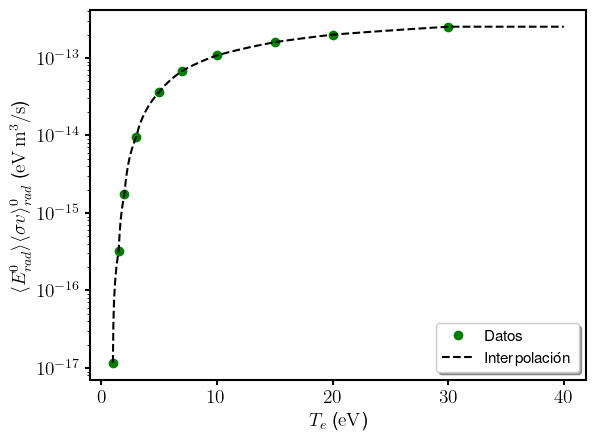

In [2]:
#Matriz interpolada
#T_e_datos en electronvolts y col_rad_0_datos
#conversión 1 W cm^3 = 6,25e12 eV m^3/s
T_e_datos = np.array([1.0, 1.5, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0, 20.0, 30.0])
col_rad_0_datos = np.array([1.87e-30, 5.14e-29, 2.80e-28, 1.51e-27, 5.81e-27, 
                            1.09e-26, 1.73e-26, 2.56e-26, 3.20e-26, 4.05e-26])*6.25e12

def Col_rad_0(T_e_datos, col_rad_0_datos):
    #Interpolación
    T_e = np.linspace(1, 40.0, 1000) #valores de temperatura
    col_rad_0 = np.interp(T_e, T_e_datos, col_rad_0_datos)

    #Graficación
    #plt.prop_cycle(color=['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97'])
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure   
    ax.plot(T_e_datos, col_rad_0_datos, 'o', linewidth=10, color= 'green', label = 'datos originales') #datos originales
    ax.plot(T_e, col_rad_0, '--', linewidth=1.5, color= 'black') #datos interpolados
    ax.set_yscale("log")
    ax.set_xlabel(r'$T_e$ (\si{\electronvolt})', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax.set_ylabel( r'$ \langle E^0_{rad} \rangle \langle \sigma v\rangle^0_{rad} $ (\si{\electronvolt.\metre^3\per\second})', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax.tick_params(axis='both', labelsize=14, width=1.5) 
    plt.setp(ax.spines.values(), linewidth=1.5)
    ax.legend((r'Datos', r'Interpolación'), loc='lower right', fontsize=11,  ncol=1, fancybox=True, shadow=True)
    if idioma == 'español':
        plt.savefig('E0_sigmv_0.png', dpi=300, bbox_inches='tight') 
    if idioma == 'ingles' :
        plt.savefig('E0_sigmv_0.eps', format='eps', dpi=300, bbox_inches='tight') #paper IOP
    plt.show()
    return T_e, col_rad_0

T_e , col_rad_0 = Col_rad_0(T_e_datos, col_rad_0_datos)

#print(T_e)
#print(col_rad_0)

## Promedio del coeficiente de impacto de ionización

Para $\langle \sigma v \rangle_{ión}$ se debe calcular en función de la temperatura a partir de la siguiente expresión
$$ \langle \sigma v \rangle_{ion} \left( T_e \right) = \exp{ \bigg\{ \sum_{i=0}^m a_i \left[ \ln \left( \frac{T_e}{eV} \right) \right]^i \bigg\}}  $$
Donde los $a_i$ son los coeficientes dados en la tabla I del artículo según el gas de trabajo.

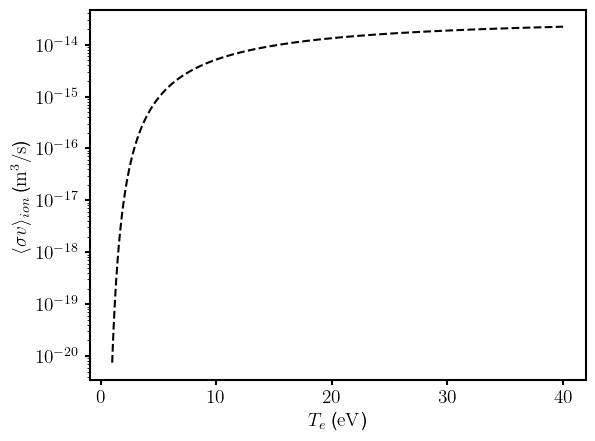

In [3]:
#Coeficientes de ajuste para el hidrógeno
coef_ion_datos = np.array([-46.34625936, 14.12846381, -6.76207354, 2.20991565, 
                           -0.51207028, 0.08100631, -0.00797476, 0.00037152])

coef_ion_lista =[]

def Coef_ion(T_e, coef_ion_datos) :
    for j in range(len(T_e)):
        arg_exp_suma = 0 #se reinicia la suma
        for i in range(len(coef_ion_datos)):
            arg_exp = coef_ion_datos[i]*np.power(np.log(T_e[j]), i) #argumento del exponencial
            arg_exp_suma += arg_exp #suma de cada término según los valores de i y j
        coef_ion_0 = np.exp(arg_exp_suma) #exponencial del resultado
        coef_ion_lista.append(coef_ion_0) # se adjunta el resultado a una matriz
    
    coef_ion = np.array(coef_ion_lista) #se transforma a numpy array
    #print(coef_ion.shape)
    
    #Graficación
    #plt.prop_cycle(color=['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97'])
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure   
    ax.plot(T_e, coef_ion, '--', linewidth=1.5, color= 'black') #datos calculados
    ax.set_yscale("log")
    ax.set_xlabel(r'$T_e$ (\si{\electronvolt})', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax.set_ylabel( r'$ \langle \sigma v \rangle_{ion} $ (\si[per-mode=symbol]{\metre^3\per\second})', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax.tick_params(axis='both', labelsize=14, width=1.5) 
    plt.setp(ax.spines.values(), linewidth=1.5)
    if idioma == 'español':
        plt.savefig('sigmv_0_col.png', dpi=300, bbox_inches='tight') 
    if idioma == 'ingles' :
        plt.savefig('sigmv_0_col.eps', format='eps', dpi=300, bbox_inches='tight') #paper IOP
    plt.show()
    
    return coef_ion

coef_ion = Coef_ion(T_e, coef_ion_datos)        
        

## Cálculo de la densidad electrónica
La ecuación para estimar la densidad electrónica es
$$
n_{e}=\dfrac{P_{\mathrm{rf}}}{Vn_{0}}\frac{1}{\left(\gamma+\frac{3}{2}\alpha\right)\langle\sigma v\rangle_{\mathrm{ion}}T_{e}+E_{\mathrm{ion}}\langle\sigma v\rangle_{\mathrm{ion}}+E_{\mathrm{rad}}^{0}\langle\sigma v\rangle_{\mathrm{rad}}^{0}}
$$
Con $P_{rf}$ la potencia entregada por los magnetrones, $n_0$ la densidad de neutros, $V$ el volumen del plasma, $\gamma$ la razón de la difusividad de calor y la difusividad de partículas y $\alpha$ la fracción de partículas en el núcleo del plasma. La densidad de neutros se calcula a partir del flujo de partículas. Si $x$ es el flujo en unidades SCCM (Standard cubic centimetres per minute) y $t$ el tiempo de inyección, la masa de hidrógeno que ingresa a la cámara, $m$ es 
$$
m = x \, [\text{SCCM}] \cdot \dfrac{7.4364\times 10^{-10} \, \text{kg}/\text{s} \cdot M}{ 1 \, \text{SCCM}} \cdot t  
$$
Se calcula la nueva densidad dentro de la cámara 
$$
\rho = \dfrac{m}{V_{cámara}} \
$$
Se transforma a densidad de partículas neutras mediante 
$$
n_0 = \dfrac{\rho \cdot N_A}{M}
$$
https://en.wikipedia.org/wiki/Standard_cubic_centimetres_per_minute 
https://www.nist.gov/pml/sensor-science/thermodynamic-metrology/unit-conversions

In [ ]:
#Cálculo de la densidad electrónica

def Densidad_electronica_max(P_rf, V, alpha, gamma, T_e, E_ion, col_rad_0, coef_ion,p_0, T_0) :
    M = 2.02 # Masa molar, unidades: kilogramo/kilomol
    #Datos de inyección
    t = 4.168 #Extraído de archivos de descarga, unidades: s
    V_camara = 0.0418 #Extraído de artículos de SCR-1 unidades: m^3
    flujo =20 
    #cálculo de la densidad de neutros
    m = flujo * 7.4364e-10*M*t #unidades: kg
    rho = m / V_camara
    #n_0 = (rho*N_A)/(M*1e-3) #factor de conversión a kg/mol
    n_0 = (p_0)/(k*T_0)
    
    print('La densidad de neutros es',n_0,'m^{-3}')
       
    
    #densidad electrónica
    frac_1 = (P_rf)/(V*n_0)
    deno_2 = ((gamma+(1.5*alpha))*coef_ion*T_e)+ (E_ion*coef_ion) + col_rad_0
    n_e = frac_1*(1/deno_2)
    
    T_e = T_e[n_e < n_0 ]
    n_e = n_e[ n_e < n_0 ] 
    #print(T_e.shape, n_e.shape)
    
    n_e = np.concatenate([np.array([n_0]),n_e]) #se conoce que en 0.02586 eV se tiene la densidad de neutros
    T_e = np.concatenate([np.array([0.02586]), T_e])

    
    #Interpolación
    f_ne = interpolate.interp1d(T_e, n_e, kind = 'linear') #funcion de densidad
    Te = np.linspace(0.02586, 40, 10000)
    ne = f_ne(Te)
    
    #print(f_ne(14.8))
    #print(ne)
    #Separación de datos para la temperatura de SCR-1 - método 2
    #https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    def find_nearest(array,value):
        idx = np.searchsorted(array, value, side="left") #Encuentra el valor más cercano en una matriz
        #if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        #    return array[idx-1]
        #else:
        #    return array[idx]
        return array[idx], idx   
    
    T_e_SCR1, indice = find_nearest(Te,15.1)
    n_e_SCR1 = ne[indice]
    print('La densidad electrónica máxima es',"{:.6e}".format(float(n_e_SCR1)),'m-3',
          'a una temperatura de', T_e_SCR1, 'eV' )
    print('La razón de densidades es', n_e_SCR1/n_0)
    
    n_e_SCR11, indice1 = find_nearest(np.sort(ne), 7.45e+16)
    T_e_sort = np.sort(Te)
    T_e_SCR11 = T_e_sort[indice1]
    print('La temperatura es',T_e_SCR11,'eV','a una densidad de,' "{:.6e}".format(float(n_e_SCR11)), 'm-3' )

    #graficación
    #plt.plot(Te, ne, '-')
    #plt.xlabel('Temperatura (eV)')
    #plt.ylabel('Densidad electrónica (m-3)')
    #plt.axis([-1, 1000, 1e17, 1e25])
    #plt.yscale("log")
    #plt.show()
    #print(Te.shape, ne.shape)
    
    return ne, Te, n_e

In [12]:
def T_Prf(V,  alpha, gamma, T_e, T_e_d, E_ion, col_rad_0, coef_ion, p_0, T_0) :
    #cálculo de la densidad de neutros
    n_0 = (p_0)/(k*T_0)
    print('La densidad de neutros es',n_0,'m^{-3}')
    ne_corte = 7.445756743205554e16
    #potencia entregada
    #
    #termino_1 = V*n_0*ne_corte
    #termino_2 = ((gamma+(1.5*alpha))*coef_ion*T_e)+ (E_ion*coef_ion) + col_rad_0
    #Prf = termino_1 * termino_2*(e)*1e-3
    
    
    __, indice = find_nearest(T_e, T_e_d)
    
    P_rf = np.linspace(0, 10, 1000)
    #densidad electrónica
    frac_1 = (P_rf*1e3*(1/e))/(V*n_0)
    deno_2 = ((gamma+(1.5*alpha))*coef_ion[indice]*T_e_d)+ (E_ion*coef_ion[indice]) + col_rad_0[indice]
    n_e = frac_1*(1/deno_2)/ne_corte
    
    
    
    
    #Graficación
    #plt.prop_cycle(color=['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97'])
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure   
    ax.plot(P_rf, n_e, '-', linewidth=1.5, color= 'black') #datos calculados
    ax.set_xlabel(r'$P_{abs}$ (\si{\kilo\watt})', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    #ax.set_ylabel( r'$ n_{e}/n_{e\,corte} $ (1)', 
                  #fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    ax.set_ylabel( r'$ n_{e}/n_{e\,cut} $ (1)', 
                  fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    ax.tick_params(axis='both', labelsize=16, width=1.5) 
    plt.setp(ax.spines.values(), linewidth=1.5)
    #plt.text(0.5,0.5, r"$n_{e \, corte} = \SI{7.445e16}{\metre^{-3}}$", fontsize =14, rotation = 30,  
             #fontdict=None, transform=ax.transAxes ) #Etiquetar gráfica
    if idioma == 'español':
        plt.savefig('n_evsP_rf.png', dpi=300, bbox_inches='tight') 
    if idioma == 'ingles' :
        plt.savefig('n_evsP_rf.eps', format='eps', dpi=300, bbox_inches='tight') #paper IOP

    #plt.savefig('n_evsP_rf.png', dpi=300, bbox_inches='tight') 
    plt.show()
    
    
    #Interpolación
    #f_prf = interpolate.interp1d(n_e, P_rf, kind = 'linear', fill_value = "extrapolate") #funcion de densidad
    #prf = np.linspace(0, 40, 10000)
    #Prf = f_prf(Te)
    
    n_e_SCR1_prf, indice1 = find_nearest(n_e,2.14)
    Prf_limite = P_rf[indice1]
    print('La potencia absorbida necesaria es de ',Prf_limite,'kW', 'para tener una razón de densidades de', n_e_SCR1_prf )
    
    
    
    #graficación
    #plt.plot(Te, Prf, '-')
    #plt.xlabel('Temperatura (eV)')
    #plt.ylabel('Potencia (kW)')
    #plt.axis([-1, 1000, 1e17, 1e25])
    #plt.yscale("log")
    #plt.show()

La densidad de neutros es 6.381179786843306e+19 m^{-3}


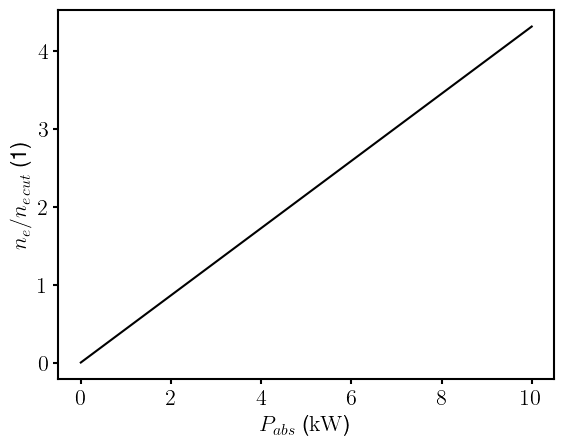

La potencia absorbida necesaria es de  4.964964964964965 kW para tener una razón de densidades de 2.1437731705688106


In [13]:
#Caso
V1 = 0.007803 #Unidad metros cúbicos. Datos brindado por VMEC
p_01 = 0.2599 #unidad pascal: presión 
T_01 = 295
alpha1 = 0.447 #Adimensional. T_e_borde/T_e_centro
gamma1 = 0 #Adimensional. 
E_ion1 = 13.6 #Unidad electronvolts. Dato brindado por el artículo
Te_pot = 15.061506150615061
T_Prf(V1,  alpha1, gamma1,T_e, Te_pot, E_ion1, col_rad_0, coef_ion, p_01, T_01)

In [ ]:
#Caso original
factor = 1
p_0 = 0.2599 #unidad pascal: presión 
T_0 = 298
#factor = 1.8 #aumento para frec ion - elec importante
original = 1.149*factor #P = P_in - P_out
P_rf = factor*original*1e3*(1/e) #Unidad: eV/s. Dato actual del magnetrón en funcionamiento
V = 0.007793 #Unidad: metros cúbicos. Datos brindado por VMEC
#flujo = 20 #unidad: SCCM 
alpha = 0.447 #Adimensional. T_e_borde/T_e_centro
gamma = 0 #Adimensional
E_ion = 13.6 #Unidad electronvolts. Dato brindado por el artículo
ne_or, Te_or, n_e_or = Densidad_electronica_max(P_rf, V, alpha, gamma, T_e, E_ion, col_rad_0, coef_ion, p_0, T_0)

In [ ]:
#Caso - Escenario 1 - optimizado
factor = 2.022
p_0 = 0.2599 #unidad pascal: presión 
T_0 = 295
original = 1.149
P_rf = factor*original*1e3*(1/e) #Unidad: eV/s. Dato actual del magnetrón en funcionamiento
V = 0.007803 #Unidad: metros cúbicos. Datos brindado por VMEC
flujo = 20 #unidad: SCCM 
alpha = 0.447 #Adimensional. T_e_borde/T_e_centro
gamma = 0 #Adimensional
E_ion = 13.6 #Unidad electronvolts. Dato brindado por el artículo
ne, Te, n_e = Densidad_electronica_max(P_rf, V, alpha, gamma, T_e, E_ion, col_rad_0, coef_ion, p_0, T_0)

In [ ]:
#Ejes compartidos
fig = plt.figure(figsize=(12, 12))  # create a figure object
ax = fig.add_subplot(2, 1, 1)  # create an axes object in the figure 
ax.plot(T_e_datos[:-1], col_rad_0_datos[:-1], 'o', linewidth=10, color= 'green', label = 'datos originales') #datos originales
ax.plot(T_e[:-500], col_rad_0[:-500], '-', linewidth=1.5, color= 'black') #datos interpolados
ax.set_yscale("log")
#ax.set_ylabel( r'$ \langle E^0_{rad} \rangle \langle \sigma v\rangle^0_{rad} $ (\si{\electronvolt.\metre^3\per\second})', 
                  #fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
ax.set_ylabel( r'$  \langle E^0_{rad} \rangle \langle \sigma v\rangle^0_{rad} $ ', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
ax.tick_params(axis='both', labelsize=14, width=1.5) 
ax.legend((r'Datos', r'Interpolación'), loc='lower right', fontsize=11,  ncol=1, fancybox=True, shadow=True)

ax1 = fig.add_subplot(2, 1, 2)  # create an axes object in the figure   
ax1.plot(T_e[:-500], coef_ion[:-500], '-', linewidth=1.5, color= 'black') #datos calculados
ax1.set_yscale("log")
#ax1.set_ylabel( r'$ \langle \sigma v \rangle_{ion} $ (\si[per-mode=symbol]{\metre^3\per\second})', 
                  #fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
ax1.set_ylabel( r'$ \langle \sigma v \rangle_{ion}  $ ', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
ax1.tick_params(axis='both', labelsize=14, width=1.5) 
ax1.set_xlabel(r'$T_e$ (\si{\electronvolt})', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})

#ax2 = fig.add_subplot(3, 1, 3)  # create an axes object in the figure   
#ax2.plot(T_e, ne, '-', linewidth=1.5, color= 'black') #datos calculados
#ax2.set_yscale("log")
#ax2.set_xlabel(r'$T_e$ (\si{\electronvolt})', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
#ax2.set_ylabel( r'$ n_{\text{e0}} $ (\si{\metre^3})', 
                  #fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
#ax2.tick_params(axis='both', labelsize=14, width=1.5) 



#Ejes marcados
plt.setp(ax.spines.values(), linewidth=1.5)
plt.setp(ax1.spines.values(), linewidth=1.5)
#plt.setp(ax2.spines.values(), linewidth=1.5)


ax.text(0.05,0.9, r"$\text{(a)}$", fontsize =14, fontdict=None, transform=ax.transAxes ) #Etiquetar gráfica
ax1.text(0.05,0.9, r'$\text{(b)}$', fontsize =14, fontdict=None, transform=ax1.transAxes) #Etiquetar gráfica fontdict = none para que intrpete latex
#ax2.text(0.05,0.9, r'$\text{(c)}$', fontsize =14, fontdict=None, transform=ax2.transAxes) #Etiquetar gráfica fontdict = none para que intrpete latex



plt.savefig('E0_sigmv_0Junto_junto.png', dpi=300, bbox_inches='tight') 
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig = plt.figure()  # crear figura

ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure   
ax.plot(Te_or, ne_or, '-', linewidth=1.5, color= 'black') #datos calculados
axins = inset_axes(ax, 2.5,1 , loc=2, bbox_to_anchor=(0.4, 0.8), bbox_transform=ax.transAxes) #Crea segundo recuadro
axins.plot(Te_or, ne_or, '-', linewidth=1.5, color= 'black') #datos calculados

#axins.set_yscale("log")
axins.set_xlim(14, 17) # apply the x-limits
axins.set_ylim(3.3e16, 6.3e16) # apply the y-limits
axins.set_xticks(np.arange(14, 17 + 0.001, 1))
axins.set_yticks(np.arange(1.7e16, 5.7e16 + 1e12, 1e16))
axins.set_xlabel(r'$T_e$ (\si{\electronvolt})', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
axins.set_ylabel( r'$ n_{e} \, (\si{\metre^{-3}}) $', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
axins.tick_params(axis='both', labelsize=14, width=1.5)
axins.yaxis.get_offset_text().set_fontsize(14) #tamaño de letra del x10
plt.setp(axins.spines.values(), linewidth=1.5)



ax.set_yscale("log")
ax.set_xlabel(r'$T_e$ (\si{\electronvolt})', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
ax.set_ylabel( r'$ n_{e} \, (\si{\metre^{-3}}) $', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
ax.tick_params(axis='both', labelsize=14, width=1.5) 
#ax1.set_yscale("log")

mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")#marca la región de interés

ax.tick_params(axis='both', labelsize=14, width=1.5)
ax.yaxis.get_offset_text().set_fontsize(14) #tamaño de letra del x10
plt.setp(ax.spines.values(), linewidth=1.5)
#ax.set_aspect(1 / ax.get_data_ratio())

if idioma == 'español':
        plt.savefig('ne0_vs_Te.png', dpi=300, bbox_inches='tight') 
if idioma == 'ingles' :
        plt.savefig('ne0_vs_Te.eps', format='eps', dpi=300, bbox_inches='tight') #paper IOP


plt.show()